In [1]:
import tensorflow as tf
import csv as csv
import cv2
import numpy as np
import time as time
import os.path
print(tf.__version__)

1.2.1


In [50]:
lines =[]
csv_file = "driving_log.csv"
with open(csv_file) as csvfile:     #Exract csv file
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)
print("Sample data from file:\n",lines[0])

Sample data from file:
 ['C:\\Users\\siby.plathottam\\Documents\\Udacity\\Behavioral_cloning\\data\\IMG\\center_2017_08_04_18_00_29_104.jpg', 'C:\\Users\\siby.plathottam\\Documents\\Udacity\\Behavioral_cloning\\data\\IMG\\left_2017_08_04_18_00_29_104.jpg', 'C:\\Users\\siby.plathottam\\Documents\\Udacity\\Behavioral_cloning\\data\\IMG\\right_2017_08_04_18_00_29_104.jpg', '0', '1', '0', '30.19117']


In [3]:
images=[]
measurements =[]

for line in lines:
    source_path=line[0]
    #print(source_path)
               
    filename = source_path.split('center')[-1] #for use in AWS instance
    #print(filename)
    current_path = 'IMG/' + 'center' + filename       #for use in AWS instance
    #current_path =  source_path #+  folder        #for use in Local machine
    if os.path.isfile(current_path) == True:
        #print(current_path)
        image_BGR = cv2.imread(current_path)            #Import image using cv2 library
        image = cv2.cvtColor(image_BGR, cv2.COLOR_BGR2RGB) #Convert BGR to RGB
        images.append(image)                 #Append image to list of images
        measurement = float(line[3])               #Import steering angle 
        measurements.append(measurement)         #Append to list of steering angle


In [4]:
#Convert to numpy array
X_train = np.array(images)       
images = None
y_train = np.array(measurements)
measurement = None

# TODO: Number of training examples
assert(len(X_train) == len(y_train))  #Check whether number of samples of input is equal to number of samples of outputs
n_train =len(X_train)
print("Image data set =",X_train.shape)
print("Number of training examples =", n_train)

Image data set = (30509, 160, 320, 3)
Number of training examples = 30509


Corresponding Steering angle = 0.0


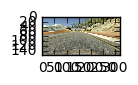

In [6]:
### Data exploration visualization code goes here.
import random
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline
index = random.randint(0, len(X_train))  #Find random image from dataset
image = X_train[index].squeeze()   


plt.figure(figsize=(1,1))
plt.imshow(image)
print("Corresponding Steering angle =",y_train[index])   #Corresponding Steering angle

In [7]:
def resize_img(image):
    import tensorflow as tf
    return tf.image.resize_images(image, (66, 66),method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)

In [23]:
use_existing = False
if os.path.isfile('model.h5') == True and use_existing == True:
    print("Model Exists...loading")
    existing_model = tf.contrib.keras.models.load_model('model.h5')
    print("Model Loaded")
    existing_model.summary()
    #print(load_model.get_config())
else:
    print("Using New Model")
    #Define model using Keras
    drop_rate = 0.5
    #bias0 = tf.contrib.keras.initializers.glorot_uniform()
    #bias0 = tf.contrib.keras.initializers.RandomUniform() 
    bias0 =  'zeros'
    
    model = tf.contrib.keras.models.Sequential() 
    model.add(tf.contrib.keras.layers.InputLayer(input_shape=(160,320,3),name='InputLayer'))  #Input
    model.add(tf.contrib.keras.layers.Cropping2D(cropping=((50,20),(0,0)),name='CropImage'))  #Cropping image
    model.add(tf.contrib.keras.layers.Lambda(resize_img,name='ResizeImage'))          #Resizing image
    model.add(tf.contrib.keras.layers.Lambda(lambda x:x/255.0 - 0.5,name='Normalizing'))  #Normalizing values

    model.add(tf.contrib.keras.layers.Conv2D(filters=4,kernel_size=(5,5),strides=(2,2),activation='relu',bias_initializer=bias0,
                                             name='ConvLayer1'))

    model.add(tf.contrib.keras.layers.Conv2D(filters=6,kernel_size=(5,5),strides=(2,2),activation='relu',bias_initializer=bias0,
                                             name='ConvLayer2'))

    model.add(tf.contrib.keras.layers.Conv2D(filters=8,kernel_size=(5,5),strides=(2,2),activation='relu',bias_initializer=bias0,
                                             name='ConvLayer3'))
    model.add(tf.contrib.keras.layers.Dropout(drop_rate,name='DropOut1'))
    model.add(tf.contrib.keras.layers.Conv2D(filters=10,kernel_size=(5,5),strides=(2,2),activation='relu',bias_initializer=bias0,
                                             name='ConvLayer4'))
    #model.add(tf.contrib.keras.layers.Dropout(drop_rate,name='DropOut1'))
    model.add(tf.contrib.keras.layers.Flatten(name='Flatten'))
    #model.add(tf.contrib.keras.layers.Dropout(drop_rate))
    model.add(tf.contrib.keras.layers.Dense(units=10,bias_initializer=bias0,name='FeedForward1'))
    model.add(tf.contrib.keras.layers.Activation('relu',name='ReLU1'))
    #model.add(tf.contrib.keras.layers.Dropout(drop_rate,name='DropOut1'))
    model.add(tf.contrib.keras.layers.Dense(units=5,bias_initializer=bias0,name='FeedForward2'))
    model.add(tf.contrib.keras.layers.Activation('relu',name='ReLU2'))
    #model.add(tf.contrib.keras.layers.Dropout(drop_rate,name='DropOut3'))
    model.add(tf.contrib.keras.layers.Dense(units=1,bias_initializer=bias0,name='OutputLayer'))
    model.compile(loss='mse',optimizer='adam')
    model.summary()


Using New Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
InputLayer (InputLayer)      (None, 160, 320, 3)       0         
_________________________________________________________________
CropImage (Cropping2D)       (None, 90, 320, 3)        0         
_________________________________________________________________
ResizeImage (Lambda)         (None, 66, 66, 3)         0         
_________________________________________________________________
Normalizing (Lambda)         (None, 66, 66, 3)         0         
_________________________________________________________________
ConvLayer1 (Conv2D)          (None, 31, 31, 4)         304       
_________________________________________________________________
ConvLayer2 (Conv2D)          (None, 14, 14, 6)         606       
_________________________________________________________________
ConvLayer3 (Conv2D)          (None, 5, 5, 8)           1208 

In [26]:
t = time.time()
model.fit(X_train,y_train,batch_size=32,epochs=3,validation_split = 0.2,shuffle =True)
print("Time: %.3f minutes" % ((time.time() - t)/60))
model.save('model.h5')
print("Model Saved")

Train on 24407 samples, validate on 6102 samples
Epoch 1/3
24407/24407 [==============================] - 15s - loss: 0.0087 - val_loss: 0.0060
Epoch 2/3
24407/24407 [==============================] - 15s - loss: 0.0086 - val_loss: 0.0057
Epoch 3/3
24407/24407 [==============================] - 15s - loss: 0.0085 - val_loss: 0.0057
Time: 0.761 minutes
Model Saved


Corresponding Steering angle = [ 0.1176471]
Prediicted Steering angle: [[ 0.12190036]]


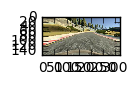

In [48]:
#Check predicted steering angle
index = random.randint(0, len(X_train))  #Find random image from dataset
samples=1
test_image = X_train[index:index+samples]
image = X_train[index].squeeze()   
plt.figure(figsize=(1,1))
plt.imshow(image)

print("Corresponding Steering angle =",y_train[index:index+samples])   #Corresponding Steering angle
print("Prediicted Steering angle:",model.predict(test_image,batch_size=1))
